## Dependencias

In [85]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

from scipy import stats
from unidecode import unidecode

from auxiliares import normalizar,freq
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Lectura de datos

In [34]:
df = pd.read_excel('../data/Cuestionario_Pyme.xlsx')

In [35]:
df.columns

Index(['Marca temporal', 'Ingresa tu número de cuenta', 'Edad', 'Sexo',
       'Escolaridad', 'Número de dependientes económicos', 'Estado Civil',
       'Ingresa la ubicación del negocio (latitud,longitud)',
       '¿La familia ayuda al negocio?',
       'Antigüedad de su negocio en años (si es menos de un año, usar su representación decimal, p.ej. 6 meses =0.5)',
       '¿A qué hora apertura su negocio?', '¿A qué hora cierra su negocio?',
       'Giro del Negocio', 'Número de empleados y/o ayudantes',
       'Ventas promedio diarias',
       'Si pudiera pedir un deseo para su negocio, ¿Cuál sería?',
       '¿Cómo registra sus ventas?', '¿Cómo registra su contabilidad?',
       '¿Está dado de alta en el SAT?',
       '¿Usa algún tipo de crédito bancario o de financiera para su negocio?',
       'En caso afirmativo ¿cuál?',
       'En caso de utilizar crédito. ¿Para que lo ha destinado generalmente?',
       '¿Cuánto tiempo de crédito le dan sus proveedores?',
       '¿Cómo promociona 

## Definición de variables

In [36]:
varc = ['Edad','Número de dependientes económicos',
        'Antigüedad de su negocio en años (si es menos de un año, usar su representación decimal, p.ej. 6 meses =0.5)',
        'Número de empleados y/o ayudantes','Ventas promedio diarias']
vard = ['Sexo','Escolaridad','Estado Civil','¿La familia ayuda al negocio?',
        'Giro del Negocio','¿Cómo registra sus ventas?', '¿Cómo registra su contabilidad?',
       '¿Está dado de alta en el SAT?',
       '¿Usa algún tipo de crédito bancario o de financiera para su negocio?',
       '¿A qué hora apertura su negocio?', '¿A qué hora cierra su negocio?',
       'En caso de utilizar crédito. ¿Para que lo ha destinado generalmente?',
       '¿Cuánto tiempo de crédito le dan sus proveedores?',
       '¿Cómo promociona su negocio? Seleccionar todas las que apliquen']
varg = ['Ingresa la ubicación del negocio (latitud,longitud)']
vartxt = ['Si pudiera pedir un deseo para su negocio, ¿Cuál sería?',
          'En caso afirmativo ¿cuál?']

In [37]:
df = df[varc+vard+varg+vartxt]

In [38]:
varc

['Edad',
 'Número de dependientes económicos',
 'Antigüedad de su negocio en años (si es menos de un año, usar su representación decimal, p.ej. 6 meses =0.5)',
 'Número de empleados y/o ayudantes',
 'Ventas promedio diarias']

In [39]:
df.rename(columns=dict(zip(varc, [
          'c_edad', 'c_dependientes', 'c_antiguedad', 'c_empleados', 'c_ventas'])), inplace=True)


In [40]:
vard

['Sexo',
 'Escolaridad',
 'Estado Civil',
 '¿La familia ayuda al negocio?',
 'Giro del Negocio',
 '¿Cómo registra sus ventas?',
 '¿Cómo registra su contabilidad?',
 '¿Está dado de alta en el SAT?',
 '¿Usa algún tipo de crédito bancario o de financiera para su negocio?',
 '¿A qué hora apertura su negocio?',
 '¿A qué hora cierra su negocio?',
 'En caso de utilizar crédito. ¿Para que lo ha destinado generalmente?',
 '¿Cuánto tiempo de crédito le dan sus proveedores?',
 '¿Cómo promociona su negocio? Seleccionar todas las que apliquen']

In [41]:
df.rename(columns=dict(zip(vard, [
          'd_sexo', 
          'd_escolaridad', 
          'd_estado_civil', 
          'd_familia', 
          'd_giro','d_registro_ventas',
          'd_registro_contabilidad',
          'd_sat',
          'd_credito',
          'd_hora_apertura',
          'd_hora_cierre',
          'd_destino_credito',
          'd_credito_proveedores','d_mercadeo'])), inplace=True)


In [42]:
df.rename(columns=dict(zip(varg, ['geopoint'])), inplace=True)
df.rename(columns=dict(zip(vartxt, ['txt_deseo', 'txt_comentario'])), inplace=True)

In [43]:
df.head(2)

,c_edad,c_dependientes,c_antiguedad,c_empleados,c_ventas,d_sexo,d_escolaridad,d_estado_civil,d_familia,d_giro,d_registro_ventas,d_registro_contabilidad,d_sat,d_credito,d_hora_apertura,d_hora_cierre,d_destino_credito,d_credito_proveedores,d_mercadeo,geopoint,txt_deseo,txt_comentario
0,54,3,35,3,3500.000,Hombre,Universidad Trunca,Casado,No,"Servicios para el hogar (cerrajería, plomería,...",En un cuaderno,En un sistema especial,Sí,No,9.000,18.000,NaN,No me dan crédito,"Publicidad exterior (lonas, pendones, etc), Re...","19.4529502,-99.2018789",Más eficacia,NaN
1,56,2,37,3,4500.000,Mujer,Universidad Terminado,Viudo,No,Comercio minorista de materias primas,En excel,En excel,Sí,No,8.000,15.000,NaN,No me dan crédito,"Publicidad exterior (lonas, pendones, etc), Re...","19.4528921,-99.2018082",Una bodega,NaN


In [44]:
varc = [v for v in df.columns if v[:2] == 'c_']
vard = [v for v in df.columns if v[:2] == 'd_']
vartxt = [v for v in df.columns if v[:3] == 'txt']


## Pre-tratamiento de datos

In [45]:
df['geopoint'] = df['geopoint'].replace(r'[^\d\.,]', '', regex=True)
df['geopoint'] = df['geopoint'].map(lambda x:x.replace('N',','))
df['geopoint'] = df['geopoint'].map(lambda x:x.replace('°',''))
df['geopoint'] = df['geopoint'].map(lambda x:x.replace('W',''))
df['geopoint'] = df['geopoint'].map(lambda x:x.replace(' ','0,0'))
df['geopoint'] = df['geopoint'].map(lambda x:x.replace(',,',','))

In [46]:
df['c_antiguedad'] = df['c_antiguedad'].replace(r'[^\d\.]', '', regex=True).astype(float)

In [47]:
df['c_ventas']  = df['c_ventas']*30.4/18

In [48]:
varg = ['geo_lat','geo_lon']

In [49]:
def parse_geopoint(s):
    try: 
        return s.split(',')
    except: 
        return  (None,None)

In [50]:
df[varg] = df['geopoint'].map(parse_geopoint).apply(pd.Series).astype(float)
df['geo_lon'] = np.where(df['geo_lon']>0,-df['geo_lon'],df['geo_lon'])

In [51]:
df.drop('geopoint',axis=1,inplace=True)

In [52]:
for v in vartxt:
    df[v] = df[v].map(lambda x:unidecode(str(x).lower()))

In [53]:
df.head(2)

,c_edad,c_dependientes,c_antiguedad,c_empleados,c_ventas,d_sexo,d_escolaridad,d_estado_civil,d_familia,d_giro,d_registro_ventas,d_registro_contabilidad,d_sat,d_credito,d_hora_apertura,d_hora_cierre,d_destino_credito,d_credito_proveedores,d_mercadeo,txt_deseo,txt_comentario,geo_lat,geo_lon
0,54,3,35.000,3,5911.111,Hombre,Universidad Trunca,Casado,No,"Servicios para el hogar (cerrajería, plomería,...",En un cuaderno,En un sistema especial,Sí,No,9.000,18.000,NaN,No me dan crédito,"Publicidad exterior (lonas, pendones, etc), Re...",mas eficacia,nan,19.453,-99.202
1,56,2,37.000,3,7600.000,Mujer,Universidad Terminado,Viudo,No,Comercio minorista de materias primas,En excel,En excel,Sí,No,8.000,15.000,NaN,No me dan crédito,"Publicidad exterior (lonas, pendones, etc), Re...",una bodega,nan,19.453,-99.202


## Análisis Exploratorio

#### Discreto

In [54]:
for v in vard:
    df[v] = df[v].fillna('MISSING')

In [55]:
for v,mapa in map(lambda v: normalizar(df,v,),vard):
    df[f'n_{v}'] = df[v].replace(mapa)

In [56]:
varn = [v for v in df.columns if v[:2] == 'n_']

In [57]:
freq(df,varn)

****Tabla de frecuencias  n_d_sexo  ***


         FA    FR  FAA   FRA
Hombre  446 0.505  446 0.505
Mujer   437 0.495  883 1.000




****Tabla de frecuencias  n_d_escolaridad  ***


                         FA    FR  FAA   FRA
Bachillerato Terminado  232 0.263  232 0.263
Bachillerato Trunco     102 0.116  334 0.378
Primaria                102 0.116  436 0.494
Secundaria              253 0.287  689 0.780
Universidad Terminado   130 0.147  819 0.928
Universidad Trunca       64 0.072  883 1.000




****Tabla de frecuencias  n_d_estado_civil  ***


              FA    FR  FAA   FRA
Casado       454 0.514  454 0.514
Divorciado    49 0.055  503 0.570
Soltero      211 0.239  714 0.809
Union Libre  121 0.137  835 0.946
Viudo         48 0.054  883 1.000




****Tabla de frecuencias  n_d_familia  ***


     FA    FR  FAA   FRA
No  323 0.366  323 0.366
Sí  560 0.634  883 1.000




****Tabla de frecuencias  n_d_giro  ***


                                                     FA    FR  FAA   FRA
Co

#### Continuo

##### Ausentes

In [58]:
miss = (df[varc].isnull().sum() / len(df)).to_frame()
miss.columns = ['miss']
display(miss)
fuera = sorted(miss[miss['miss']>0.3].index)
fuera

,miss
c_edad,0.000
c_dependientes,0.000
c_antiguedad,0.000
c_empleados,0.000
c_ventas,0.099


[]

In [59]:
im = SimpleImputer(strategy='median')
Xi = pd.DataFrame(im.fit_transform(df[varc]),columns=varc)

In [60]:
ks = pd.DataFrame(map(lambda v:(v,stats.ks_2samp(df[v].dropna(),Xi[v]).statistic),varc),columns=['var','ks'])
ks = ks.sort_values('ks',ascending=False)
ks

,var,ks
4,c_ventas,0.048
0,c_edad,0.000
1,c_dependientes,0.000
2,c_antiguedad,0.000
3,c_empleados,0.000


In [61]:
df[varc] = im.transform(df[varc])

In [62]:
(df['c_ventas']*30/18).describe()

count      883.000
mean      6796.920
std       9915.890
min          0.000
25%       1688.889
50%       4222.222
75%       8444.444
max     168888.889
Name: c_ventas, dtype: float64

In [63]:
df.to_parquet('../data/df_pymes.parquet')

## Visualización de datos en espacios reducidos

In [74]:
pipe_pca = make_pipeline(StandardScaler(),PCA(n_components=3),MinMaxScaler()) 
pipe_pca.fit(df[varc])
Xp = pd.DataFrame(pipe_pca.transform(df[varc]),columns=['d1','d2','d3'])
print(pipe_pca.steps[1][1].explained_variance_ratio_.cumsum())
Xp.head(2)

[0.26799418 0.50973316 0.70975291]


,d1,d2,d3
0,0.645,0.173,0.079
1,0.681,0.164,0.078


In [78]:
sc = MinMaxScaler()
mds = MDS(n_components=3,n_jobs=-1,normalized_stress='auto')
Xm = pd.DataFrame(sc.fit_transform(mds.fit_transform(df[varc])),columns=['d1','d2','d3'])

Xm.head(2)

,d1,d2,d3
0,0.774,0.950,0.073
1,0.784,0.936,0.095


In [81]:
Xp.iplot(kind='scatter3d', x='d1', y='d2', z='d3',
         mode='markers', size=10, color='purple')
Xm.iplot(kind='scatter3d', x='d1', y='d2', z='d3',
         mode='markers', size=10, color='purple')


## Warm Clustering

In [82]:
sc = MinMaxScaler()
Xs = pd.DataFrame(sc.fit_transform(df[varc]),columns=varc)

In [86]:
sil = []
for k in range(2,10):
    cl = KMeans(n_clusters=k)
    cl.fit(Xs[varc])
    sil.append((k,silhouette_score(Xs[varc],cl.predict(Xs[varc]))))
sil = pd.DataFrame(sil,columns=['k','sil']).set_index('k')
sil.iplot(kind='line',mode='lines+markers',size=10)

/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans

In [90]:
k = 5
sk = SelectKBest(k=len(varc))
sk.fit(Xs[varc], cl.predict(Xs[varc]))
pd.Series(dict(zip(varc, sk.scores_))).sort_values(
    ascending=False).iplot(kind='bar')


In [94]:
sk = SelectKBest(k=2)
sk.fit(Xs[varc], cl.predict(Xs[varc]))
best = list(np.array(varc)[sk.get_support()])
best

['c_edad', 'c_antiguedad']

## Clustering

### Aglomerativo (Jerárquico)

In [97]:
agg = AgglomerativeClustering(n_clusters=k)
Xs['agg'] = df['agg'] = Xp['agg'] = Xm['agg'] = pd.Series(
    agg.fit_predict(Xs[best])).map(lambda x: "CL%02d" % x)


### Optimización (K-Medias)

In [98]:
kme = KMeans(n_clusters=k)
kme.fit(Xs[best])
Xs['kme'] = df['kme'] = Xp['kme'] = Xm['kme'] = pd.Series(
    kme.predict(Xs[best])).map(lambda x: "CL%02d" % x)


/home/jose/entornos/amv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Densidad (Modelos Gaussianos Mixtos)

In [99]:
gmm = GaussianMixture(n_components=k)
gmm.fit(Xs[best])
Xs['gmm'] = df['gmm'] = Xp['gmm'] = Xm['gmm'] = pd.Series(
    gmm.predict(Xs[best])).map(lambda x: "CL%02d" % x)


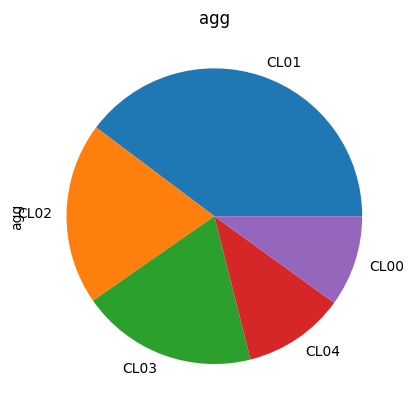

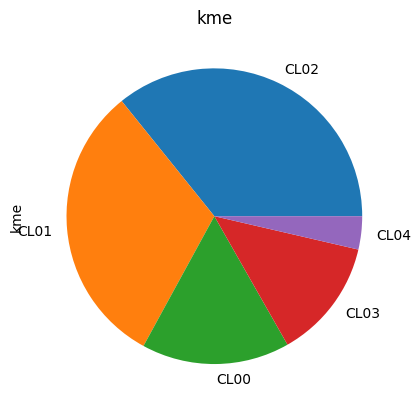

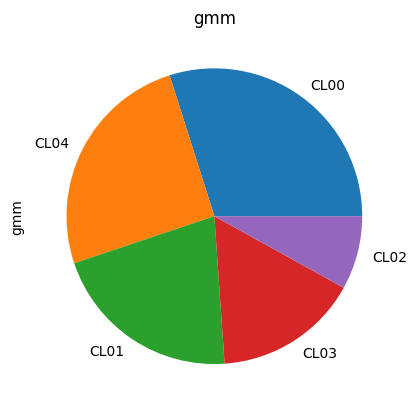

In [103]:
for cl in ['agg','kme','gmm']:
    plt.figure()
    df[cl].value_counts().plot(kind='pie',title=cl)

In [104]:
pd.DataFrame(map(lambda cl: (cl, silhouette_score(Xs[best], Xs[cl])), [
             'agg', 'kme', 'gmm']), columns=['cl', 'sil']).set_index('cl').iplot(kind='bar', color='purple')


## Visualización del cluster

In [105]:
cl = 'kme'

In [107]:
Xp.iplot(kind='scatter3d', x='d1', y='d2', z='d3',categories=cl)

Xm.iplot(kind='scatter3d', x='d1', y='d2', z='d3',categories=cl)

## Perfilamiento (Obtención de arquetipos)

In [118]:
df[cl].value_counts(1).sort_index()

CL00   0.162
CL01   0.313
CL02   0.358
CL03   0.131
CL04   0.036
Name: kme, dtype: float64

<Axes: title={'center': 'kme'}, ylabel='kme'>

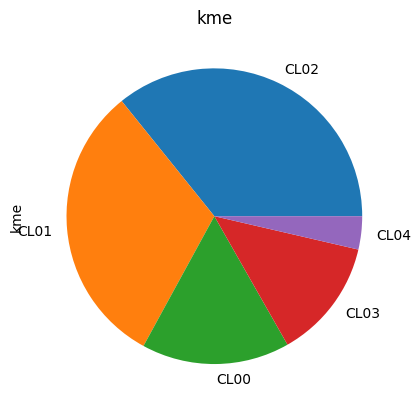

In [116]:
df[cl].value_counts().plot(kind='pie',title=cl)

### Continuo

In [120]:
display(df[best+[cl,'c_ventas']].groupby(cl).mean())
df[best+['c_ventas']].mean().to_frame().T

,c_edad,c_antiguedad,c_ventas
kme,,,
CL00,65.042,13.912,3753.219
CL01,32.069,5.399,3889.181
CL02,47.718,9.140,4207.322
CL03,55.681,33.397,4265.551
CL04,36.375,46.719,5205.208


,c_edad,c_antiguedad,c_ventas
0,46.267,13.292,4078.152


In [122]:
arq = {"CLOO": "Viejitos ventas bajas, escolaridad baja",
       "CL01": "Jóvenes con nuevos negocios",
       "CL02": "GenX con negocios nuevos",
       "CL03": "Viejitos con negocios consolidados",
       "CL04": "Jóvenes Varones herederos de negocios consolidados, con mayor escolaridad"}


### Discreto

In [115]:
for v in varn:
    aux = df[[v, cl]].assign(n=1).pivot_table(
        index=v, columns=cl, values='n', aggfunc='sum', fill_value=0)
    aux/=aux.sum()
    aux.T.iplot(kind='bar', barmode='stack', title=v)

In [125]:
from keplergl import KeplerGl

In [135]:
aux = df[['geo_lat','geo_lon',cl]].copy()
aux[cl] =aux[cl].astype(str) 

In [139]:
mapa = KeplerGl(height=600, width=800)
mapa.add_data(aux)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [141]:
mapa.save_to_html(file_name='mapita.html')

Map saved to mapita.html!
